# Pose Graph Optimization

In [1]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.7 MB/s eta 0:00:00


Mount the notebook to our drive so we can load data and import from other python files.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time

In [4]:
project_path = '/content/drive/Shareddrives/CS361 Final Project/'

# Add this folder to our path so we can import from python files in it
import sys
sys.path.append(project_path)

# Load the data files
data_path = project_path + 'data/'
odometry_data = np.load(data_path + 'odometry.npz')
gnss_data = np.load(data_path + 'gnss.npz')
ground_truth_data = np.load(data_path + 'ground_truth.npz')

We extract the numpy arrays stored in the data files. $N$ is the length of the trajectory, $N_{sats}$ is the number of satellites visible throughout the trajectory, which is a constant here.

- `odom_rotations`: array of shape $(N-1)$ x $3$ x $3$ containing $3$ x $3$ rotation matrices at each timestep
- `odom_translations`: array of shape $(N-1)$ x $3$ containing translation vectors at each timestep
- `sv_positions`: array of shape $N$ x $N_{sats}$ x $3$ containing the satellite positions in ENU at each timestep
- `pranges`: array of shape $N$ x $N_{sats}$ containing the pseudoranges from each satellite to the vehicle at each timestep. These pseudoranges are generated by computing true ranges from the satellites to the vehicle ground truth and adding Gaussian noise with standard deviation of 6 m
- `gt_positions`: array of shape $N$ x $3$ containing ground truth vehicle positions for the trajectory.
- `gt_rotations`: array of shape $N$ x $3$ x $3$ containing rotation matrices describing the orientation of the vehicle throughout the trajectory.

In [5]:
# Parameters
N = 4500
N_SATS = 9
optimize_3D = False
n = 3 if optimize_3D else 2

In [6]:
odom_rotations = odometry_data['rotations']
odom_translations = odometry_data['translations']
sv_positions = gnss_data['sv_positions'][:N]
pranges = gnss_data['pranges'][:N]
gt_positions = ground_truth_data['translations'][:N]
gt_rotations = ground_truth_data['rotations'][:N]

We plot the ground truth in 2D. We mark the start with a marker and color-code by trajectory index (blue=start, yellow=end) to better visualize the progression from start to end.

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=gt_positions[:, 0], y=gt_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), showlegend=False))
fig.add_trace(go.Scatter(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=800, height=800, scene_aspectmode='data', title={'text': '2D Ground Truth', 'x': 0.5}, xaxis_title='X (m)', yaxis_title='Y (m)')
fig.write_image("2D_ground_truth.png")
fig.show()

We now plot the ground truth in 3D

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=gt_positions[:, 0], y=gt_positions[:, 1], z=gt_positions[:, 2], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), showlegend=False))
fig.add_trace(go.Scatter3d(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], z=[gt_positions[0, 2]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=1200, height=800, scene_aspectmode='data', title={'text': '3D Ground Truth', 'x': 0.5}, scene=dict(xaxis_title='X (m)', yaxis_title='Y (m)', zaxis_title='Z (m)'))
fig.show()

## (a) Odometry only

As a first step, we'll use only the odometry data to estimate the vehicle trajectory. We extract the odometry data (rotation matrices and translation vectors) into a list of tuples $\{(R_1, t_1), \dots, (R_{N-1}, t_{N-1})\}$, where $(R_i, t_i)$ is the estimated transformation from pose $T_i$ to $T_{i+1}$.

In [9]:
odoms = [] # list of (R, t) tuples
for i in range(N - 1):
  odoms.append((odom_rotations[i][:n, :n], odom_translations[i][:n]))

We estimate the trajectory with odometry only by sequentially composing the current pose with the transformation pose from odometry.

In [10]:
from utils import Pose

In [11]:
odom_poses = []
# Initialize the first pose from ground truth
initial_pose = Pose(gt_rotations[0][:n, :n], gt_positions[0][:n])
odom_poses.append(initial_pose)

odom_positions = np.zeros((N, n))
odom_positions[0, :] = initial_pose.t

for i in range(N - 1):
  current_pose = odom_poses[i]
  Rc, tc = current_pose.R, current_pose.t
  # use odometry
  Rn = Rc @ odoms[i][0]
  tn = Rc @ odoms[i][1] + tc
  next_pose = Pose(Rn, tn)

  odom_positions[i + 1, :] = next_pose.t
  odom_poses.append(next_pose)

We then plot the estimated trajectory from odometry and compare with the ground truth.

In [12]:
# Odometry trajectory plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=gt_positions[:, 0], y=gt_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), name='Ground Truth'))
fig.add_trace(go.Scatter(x=odom_positions[:, 0], y=odom_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(odom_positions))), name='Odometry'))
fig.add_trace(go.Scatter(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=800, height=800, scene_aspectmode='data', title={'text': '2D Ground Truth and Odometry', 'x': 0.5}, xaxis_title='X (m)', yaxis_title='Y (m)')
fig.write_image("2D_ground_truth_and_odometry.png")
fig.show()

In [13]:
if optimize_3D:
  fig = go.Figure()
  fig.add_trace(go.Scatter3d(x=gt_positions[:, 0], y=gt_positions[:, 1], z=gt_positions[:, 2], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), name='Ground Truth'))
  fig.add_trace(go.Scatter3d(x=odom_positions[:, 0], y=odom_positions[:, 1], z=odom_positions[:, 2], mode='markers', marker=dict(size=2, color=np.arange(len(odom_positions))), name='Odometry'))
  fig.add_trace(go.Scatter3d(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], z=[gt_positions[0, 2]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
  fig.update_layout(width=1200, height=800, scene_aspectmode='data', title={'text': '3D Ground Truth and Odometry', 'x': 0.5}, scene=dict(xaxis_title='X (m)', yaxis_title='Y (m)', zaxis_title='Z (m)'))
  fig.show()

We compute the RMSE error of the odometry trajectory with respect to ground truth

In [14]:
odom_RMSE = np.mean(np.linalg.norm(gt_positions[:, :n] - odom_positions[:, :n], axis=1) ** 2) ** 0.5
print(odom_RMSE)

104.16411953418756


We plot the $x$ and $y$ positions from odometry and compare with the ground truth on separate plots

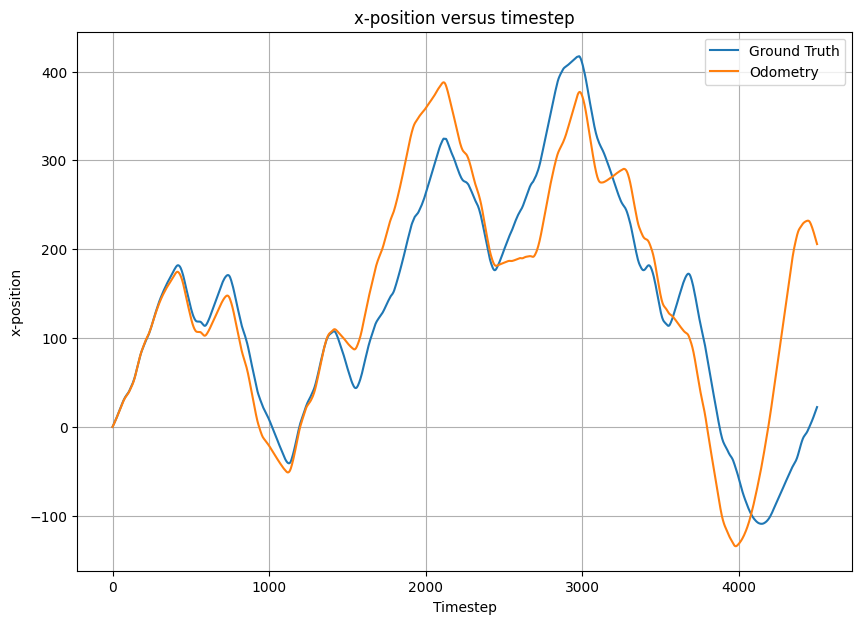

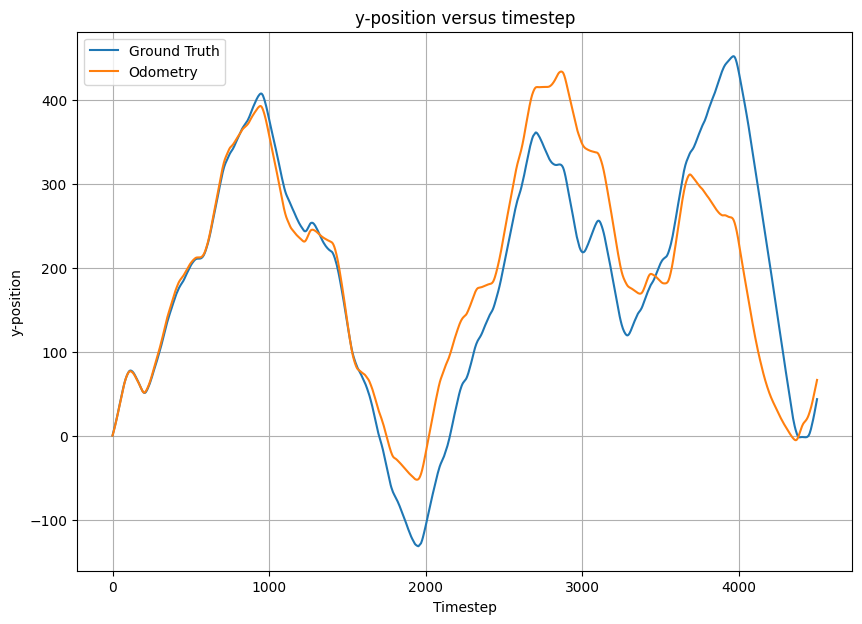

In [15]:
# Plot the x position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 0], label='Ground Truth')
plt.plot(np.arange(N), odom_positions[:, 0], label='Odometry')
plt.legend()
plt.title('x-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('x-position')
plt.grid(True)
plt.savefig("x_odom.png")
plt.show()

# Plot the y position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 1], label='Ground Truth')
plt.plot(np.arange(N), odom_positions[:, 1], label='Odometry')
plt.legend()
plt.title('y-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('y-position')
plt.grid(True)
plt.savefig("y_odom.png")
plt.show()

## (b) GPS ranges only

Next, we will estimate the trajectory again, this time using GPS ranges only.

In [16]:
# We import the solve_position function
from range_localization import solve_position

Using the `sv_positions` and `pranges` arrays, we solve for the position of the vehicle at each timestep using the `solve_position` function and save the positions in the `gps_positions` array.

In [17]:
gps_positions = np.zeros((N, 3)) # use GPS for 3D only
for i in range(N):
  x_0 = np.array([0.0, 0.0, 0.0])
  gps_positions[i, :] = solve_position(x_0, sv_positions[i], pranges[i])

We then plot the estimated trajectory from GPS ranges and compare with the ground truth.

In [18]:
# GPS trajectory plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=gt_positions[:, 0], y=gt_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), name='Ground Truth'))
fig.add_trace(go.Scatter(x=gps_positions[:, 0], y=gps_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(gps_positions))), name='GPS'))
fig.add_trace(go.Scatter(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=800, height=800, scene_aspectmode='data', title={'text': '2D Ground Truth and GPS', 'x': 0.5}, xaxis_title='X (m)', yaxis_title='Y (m)')
fig.write_image("2D_ground_truth_and_GPS.png")
fig.show()

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=gt_positions[:, 0], y=gt_positions[:, 1], z=gt_positions[:, 2], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), name='Ground Truth'))
fig.add_trace(go.Scatter3d(x=gps_positions[:, 0], y=gps_positions[:, 1], z=gps_positions[:, 2], mode='markers', marker=dict(size=2, color=np.arange(len(gps_positions))), name='GPS'))
fig.add_trace(go.Scatter3d(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], z=[gt_positions[0, 2]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=1200, height=800, scene_aspectmode='data', title={'text': '3D Ground Truth and GPS', 'x': 0.5}, scene=dict(xaxis_title='X (m)', yaxis_title='Y (m)', zaxis_title='Z (m)'))
fig.show()

We compute the RMSE error of the GPS trajectory with respect to ground truth

In [20]:
gps_RMSE = np.mean(np.linalg.norm(gt_positions[:, :n] - gps_positions[:, :n], axis=1) ** 2) ** 0.5
print(gps_RMSE)

4.9289114284694815


We plot the $x$ and $y$ positions from GPS and compare with the ground truth on separate plots

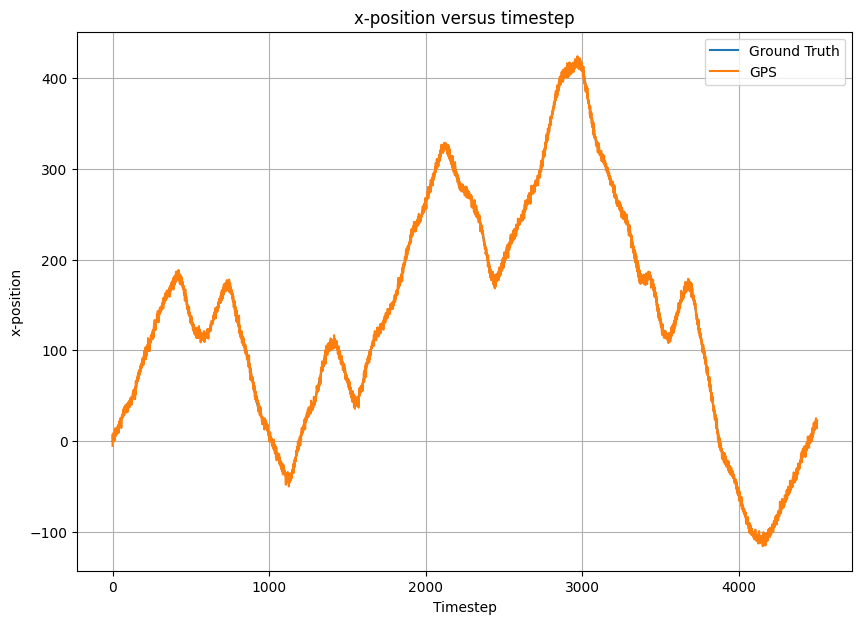

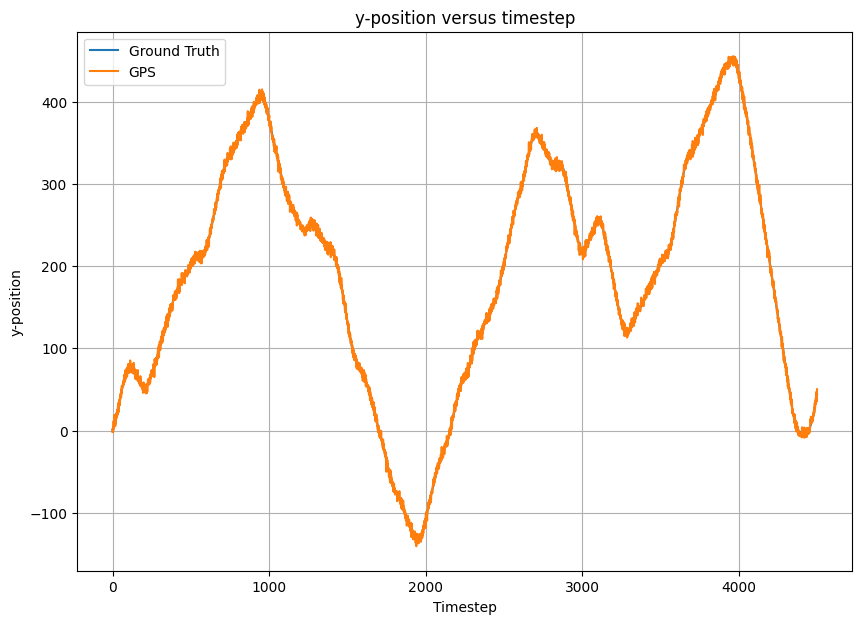

In [21]:
# Plot the x position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 0], label='Ground Truth')
plt.plot(np.arange(N), gps_positions[:, 0], label='GPS')
plt.legend()
plt.title('x-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('x-position')
plt.grid(True)
plt.savefig("x_gps.png")
plt.show()

# Plot the y position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 1], label='Ground Truth')
plt.plot(np.arange(N), gps_positions[:, 1], label='GPS')
plt.legend()
plt.title('y-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('y-position')
plt.grid(True)
plt.savefig("y_gps.png")
plt.show()

## (c) Fusing odometry and ranges with PGO

Now that we've tried estimating the trajectory with odometry only and ranging only and see the downsides of both alone, we will use pose graph optimization (PGO) to solve for the trajectory using both together.

In [22]:
# We import the build_and_optimize_pose_graph function
from pose_graph_optimization import build_and_optimize_pose_graph

Using `sv_positions`, `pranges` and `odoms`, we solve for the position of the vehicle using the `build_and_optimize_pose_graph` function and save the positions in the `graph_positions` array.

In [23]:
graph_positions = build_and_optimize_pose_graph(sv_positions, pranges, odoms, window_size=9, shift=3, sigma_gps=6.0, sigma_R=0.05, sigma_t=0.01, optimize_3D=optimize_3D)

100%|██████████| 1498/1498 [01:33<00:00, 15.99it/s]


We then plot the estimated trajectory from PGO and compare with the ground truth.

In [24]:
# PGO trajectory plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=gt_positions[:, 0], y=gt_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), name='Ground Truth'))
fig.add_trace(go.Scatter(x=graph_positions[:, 0], y=graph_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(graph_positions))), name='PGO'))
fig.add_trace(go.Scatter(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=800, height=800, scene_aspectmode='data', title={'text': '2D Ground Truth and PGO', 'x': 0.5}, xaxis_title='X (m)', yaxis_title='Y (m)')
fig.write_image("2D_ground_truth_and_PGO_W9_S3.png")
fig.show()

In [25]:
if optimize_3D:
  fig = go.Figure()
  fig.add_trace(go.Scatter3d(x=gt_positions[:, 0], y=gt_positions[:, 1], z=gt_positions[:, 2], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), name='Ground Truth'))
  fig.add_trace(go.Scatter3d(x=graph_positions[:, 0], y=graph_positions[:, 1], z=graph_positions[:, 2], mode='markers', marker=dict(size=2, color=np.arange(len(graph_positions))), name='PGO'))
  fig.add_trace(go.Scatter3d(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], z=[gt_positions[0, 2]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
  fig.update_layout(width=1200, height=800, scene_aspectmode='data', title={'text': '3D Ground Truth and PGO', 'x': 0.5}, scene=dict(xaxis_title='X (m)', yaxis_title='Y (m)', zaxis_title='Z (m)'))
  fig.show()

We compute the RMSE error of the PGO trajectory with respect to ground truth

In [26]:
graph_RMSE = np.mean(np.linalg.norm(gt_positions[:, :n] - graph_positions[:, :n], axis=1) ** 2) ** 0.5
print("RMSE", graph_RMSE)

RMSE 1.5208558818134617


We plot the $x$ and $y$ positions from PGO and compare with the ground truth on separate plots

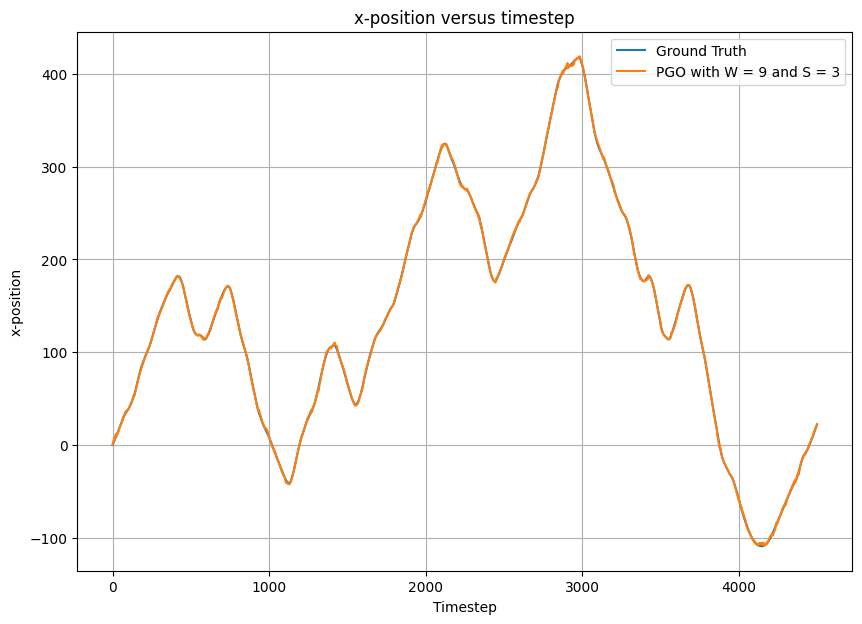

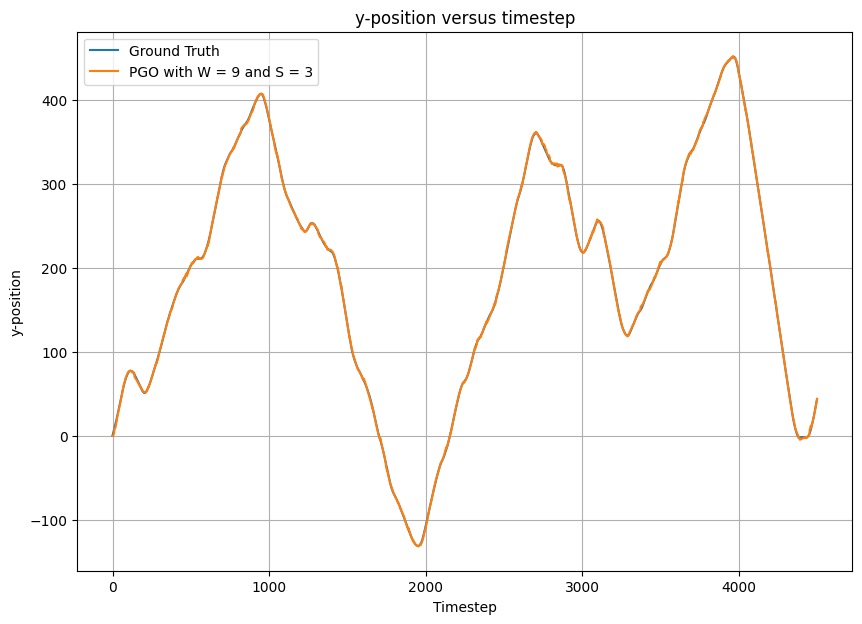

In [27]:
# Plot the x position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 0], label='Ground Truth')
plt.plot(np.arange(N), graph_positions[:, 0], label='PGO with W = 9 and S = 3')
plt.legend()
plt.title('x-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('x-position')
plt.grid(True)
plt.savefig("x_pgo_W9S3.png")
plt.show()

# Plot the y position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 1], label='Ground Truth')
plt.plot(np.arange(N), graph_positions[:, 1], label='PGO with W = 9 and S = 3')
plt.legend()
plt.title('y-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('y-position')
plt.grid(True)
plt.savefig("y_pgo_W9S3.png")
plt.show()

## (d) Hyperparameter tuning for 2D PGO

Even though there are multiple hyperparameters such as window size, shifting amount, odometry standard deviation values and optimizer max iterations, we focus on the 2 most important ones: Window size $W$ and shift amount $S$.

#### (i) Vary shift $S$, keep window size $W$ fixed.

In [28]:
W = 60
S_vals = [10, 20, 30, 40, 50]
results = []

for S in S_vals:
  start_time = time.time()
  graph_positions = build_and_optimize_pose_graph(sv_positions, pranges, odoms, window_size=W, shift=S, sigma_gps=6.0, sigma_R=0.05, sigma_t=0.01, optimize_3D=False)
  end_time = time.time()
  total_time = end_time - start_time
  graph_RMSE = np.mean(np.linalg.norm(gt_positions[:, :2] - graph_positions[:, :2], axis=1) ** 2) ** 0.5
  print(f"\nFor W = {W} and S = {S}, RMSE: {graph_RMSE} metres and time taken: {total_time} seconds\n")
  results.append((graph_RMSE, total_time))

100%|██████████| 445/445 [16:06<00:00,  2.17s/it]



For W = 60 and S = 10, RMSE: 0.9148066259089969 metres and time taken: 966.1058912277222 seconds



100%|██████████| 223/223 [08:06<00:00,  2.18s/it]



For W = 60 and S = 20, RMSE: 0.8689695444346834 metres and time taken: 486.118994474411 seconds



100%|██████████| 149/149 [05:22<00:00,  2.16s/it]



For W = 60 and S = 30, RMSE: 0.8351674355560933 metres and time taken: 322.3452956676483 seconds



100%|██████████| 112/112 [04:20<00:00,  2.32s/it]



For W = 60 and S = 40, RMSE: 0.8817034611232831 metres and time taken: 260.1503918170929 seconds



100%|██████████| 89/89 [03:32<00:00,  2.39s/it]


For W = 60 and S = 50, RMSE: 3.0355269582335933 metres and time taken: 212.52622079849243 seconds



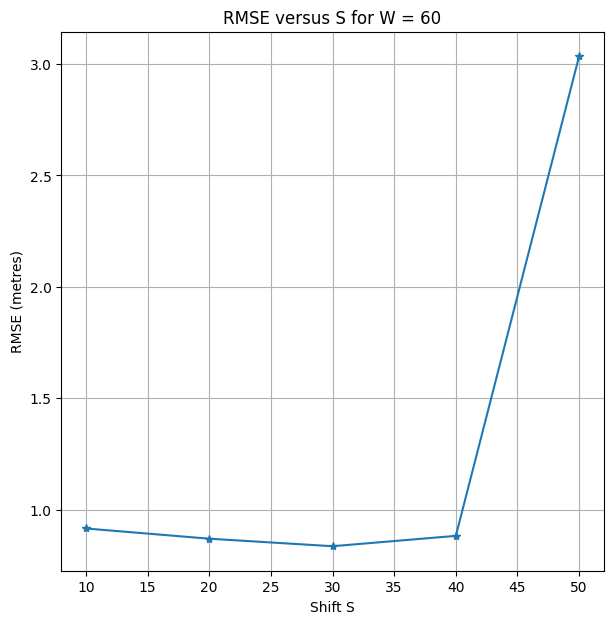

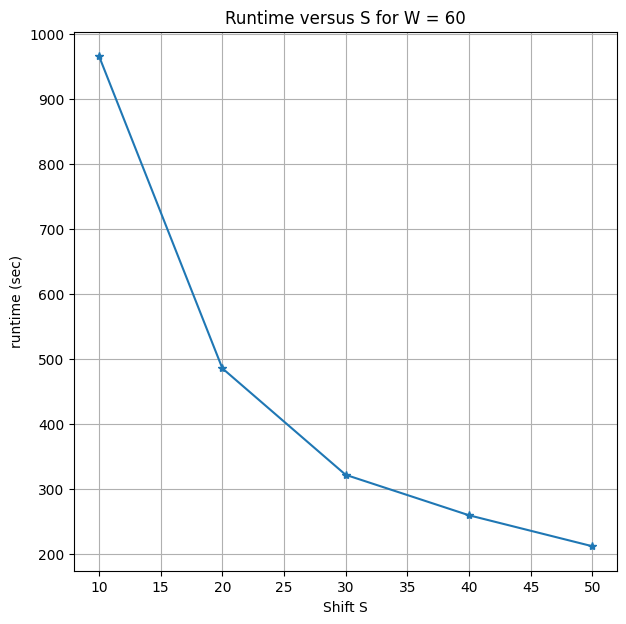

In [29]:
errors = [result[0] for result in results]
times = [result[1] for result in results]

plt.figure(figsize=(7, 7))
plt.plot(S_vals, errors, '*-')
plt.title('RMSE versus S for W = 60')
plt.xlabel('Shift S')
plt.ylabel('RMSE (metres)')
plt.grid(True)
plt.savefig("RMSE_vs_S.png")
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(S_vals, times, '*-')
plt.title('Runtime versus S for W = 60')
plt.xlabel('Shift S')
plt.ylabel('runtime (sec)')
plt.grid(True)
plt.savefig("Runtime_vs_S.png")
plt.show()

#### (ii) Vary window size $W$, keep shift $S$ fixed.

In [30]:
W_vals = [30, 40, 50, 60, 70]
S = 30
results = []

for W in W_vals:
  start_time = time.time()
  graph_positions = build_and_optimize_pose_graph(sv_positions, pranges, odoms, window_size=W, shift=S, sigma_gps=6.0, sigma_R=0.05, sigma_t=0.01, optimize_3D=False)
  end_time = time.time()
  total_time = end_time - start_time
  graph_RMSE = np.mean(np.linalg.norm(gt_positions[:, :2] - graph_positions[:, :2], axis=1) ** 2) ** 0.5
  print(f"\nFor W = {W} and S = {S}, RMSE: {graph_RMSE} metres and time taken: {total_time} seconds\n")
  results.append((graph_RMSE, total_time))

100%|██████████| 150/150 [03:25<00:00,  1.37s/it]



For W = 30 and S = 30, RMSE: 1.1489997393542237 metres and time taken: 205.1353476047516 seconds



100%|██████████| 149/149 [02:44<00:00,  1.11s/it]



For W = 40 and S = 30, RMSE: 2.7910249988903484 metres and time taken: 164.721999168396 seconds



100%|██████████| 149/149 [04:01<00:00,  1.62s/it]



For W = 50 and S = 30, RMSE: 2.244650180924838 metres and time taken: 241.67836833000183 seconds



100%|██████████| 149/149 [05:23<00:00,  2.17s/it]



For W = 60 and S = 30, RMSE: 0.8351674355560933 metres and time taken: 323.25417470932007 seconds



100%|██████████| 148/148 [07:19<00:00,  2.97s/it]


For W = 70 and S = 30, RMSE: 2.7056091956091404 metres and time taken: 439.6363708972931 seconds



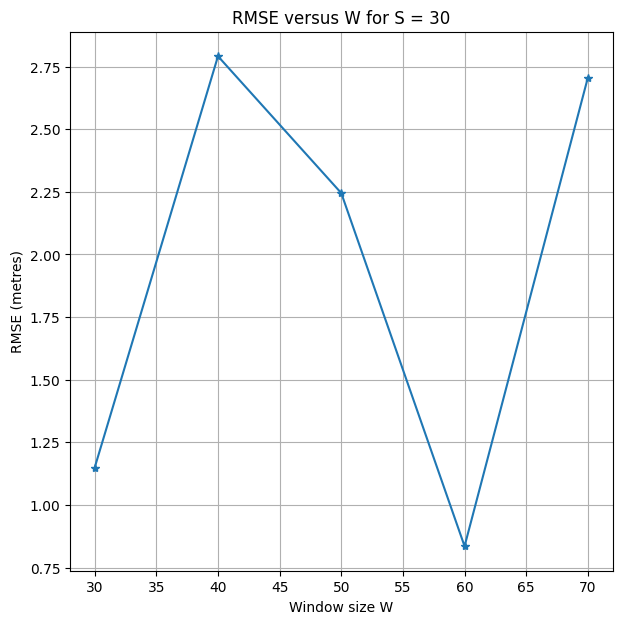

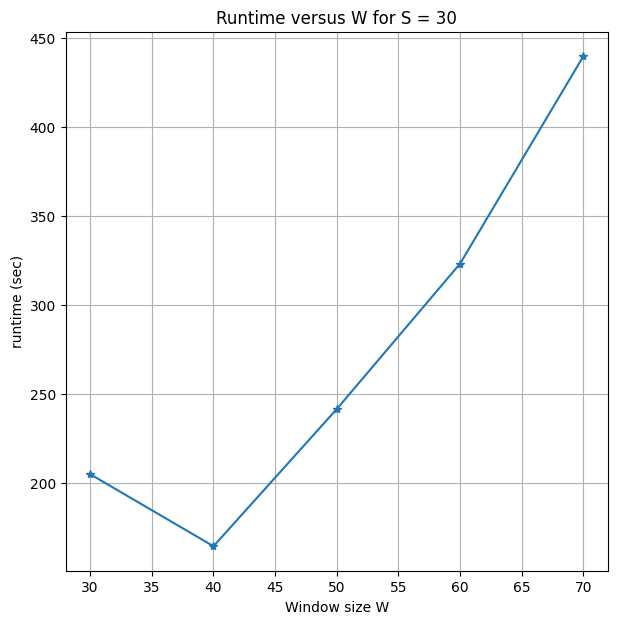

In [31]:
errors = [result[0] for result in results]
times = [result[1] for result in results]

plt.figure(figsize=(7, 7))
plt.plot(W_vals, errors, '*-')
plt.title('RMSE versus W for S = 30')
plt.xlabel('Window size W')
plt.ylabel('RMSE (metres)')
plt.grid(True)
plt.savefig("RMSE_vs_W.png")
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(W_vals, times, '*-')
plt.title('Runtime versus W for S = 30')
plt.xlabel('Window size W')
plt.ylabel('runtime (sec)')
plt.grid(True)
plt.savefig("Runtime_vs_W.png")
plt.show()

## (e) Final results

From the hyperparameter tuning above, we find that $W=60$ and $S=30$ gives us the best results. We optimize for this case and plot our results.

In [32]:
graph_positions = build_and_optimize_pose_graph(sv_positions, pranges, odoms, window_size=60, shift=30, sigma_gps=6.0, sigma_R=0.05, sigma_t=0.01, optimize_3D=False)

100%|██████████| 149/149 [05:22<00:00,  2.16s/it]


In [33]:
# PGO trajectory plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=gt_positions[:, 0], y=gt_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(gt_positions))), name='Ground Truth'))
fig.add_trace(go.Scatter(x=graph_positions[:, 0], y=graph_positions[:, 1], mode='markers', marker=dict(size=2, color=np.arange(len(graph_positions))), name='PGO'))
fig.add_trace(go.Scatter(x=[gt_positions[0, 0]], y=[gt_positions[0, 1]], mode='markers', marker=dict(size=7, color='darkblue'), name='Start'))
fig.update_layout(width=800, height=800, scene_aspectmode='data', title={'text': '2D Ground Truth and PGO', 'x': 0.5}, xaxis_title='X (m)', yaxis_title='Y (m)')
fig.write_image("2D_ground_truth_and_PGO_W60_S30.png")
fig.show()

In [34]:
graph_RMSE = np.mean(np.linalg.norm(gt_positions[:, :2] - graph_positions[:, :2], axis=1) ** 2) ** 0.5
print("RMSE", graph_RMSE)

RMSE 0.8351674355560933


In [35]:
x_max_error = np.max(np.abs(gt_positions[:, 0] - graph_positions[:, 0]))
y_max_error = np.max(np.abs(gt_positions[:, 1] - graph_positions[:, 1]))
print(f"Maximum absolute error in x-position: {x_max_error}")
print(f"Maximum absolute error in y-position: {y_max_error}")

Maximum absolute error in x-position: 2.168574143520786
Maximum absolute error in y-position: 5.641004885576031


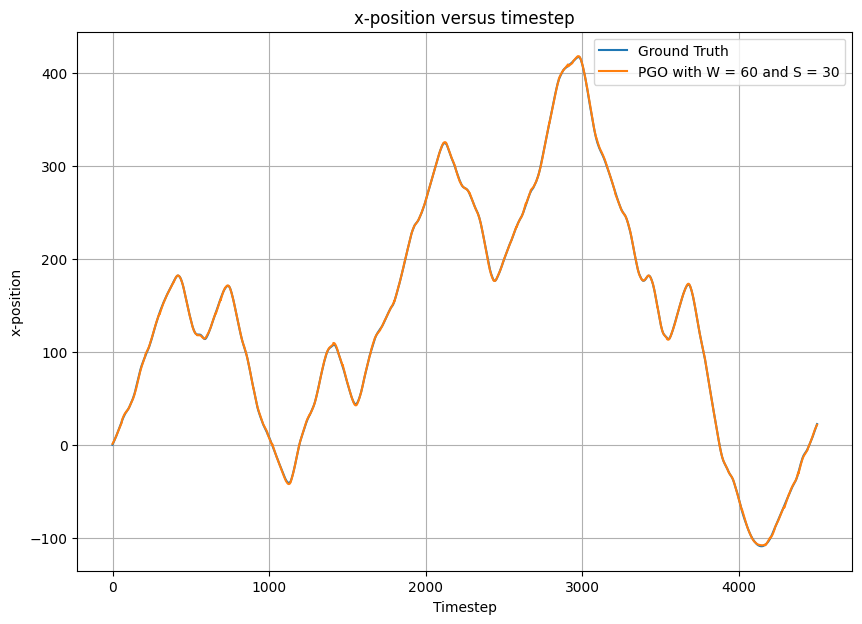

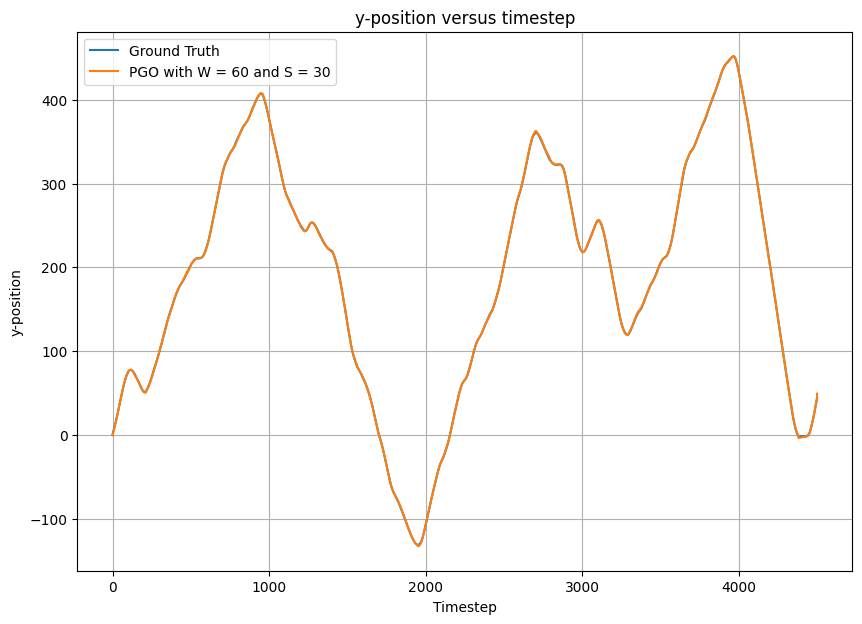

In [36]:
# Plot the x position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 0], label='Ground Truth')
plt.plot(np.arange(N), graph_positions[:, 0], label='PGO with W = 60 and S = 30')
plt.legend()
plt.title('x-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('x-position')
plt.grid(True)
plt.savefig("x_pgo_W60S30.png")
plt.show()

# Plot the y position
plt.figure(figsize=(10, 7))
plt.plot(np.arange(N), gt_positions[:, 1], label='Ground Truth')
plt.plot(np.arange(N), graph_positions[:, 1], label='PGO with W = 60 and S = 30')
plt.legend()
plt.title('y-position versus timestep')
plt.xlabel('Timestep')
plt.ylabel('y-position')
plt.grid(True)
plt.savefig("y_pgo_W60S30.png")
plt.show()